# Week 14

### Topic
 1. Intro to our gaussian mixture models
 1. Fit Gaussian mixture model with a GLM
    1. Plot GLM model with `contour`
 1. IN GROUPS (Skip for online): try with different seeds
 1. BACK TO SLIDES TO TALK ABOUT ISSUES WITH LOGISTIC REGRESSION
 1. Redo decision boundary with KNN
 1. Example: KNN with the boston cream donut distribution


In [1]:
# resize
require(repr)
options(repr.plot.width=8, repr.plot.height=5)

Loading required package: repr


Following: K-nearest neighbors, https://idc9.github.io/stor390/notes/cross_validation/cross_validation.html

To probe KNN a bit more what we are gonna do is
  1. generate some "fake" sample data from a known distribution
  1. use this fake data to "train" our KNN
  1. see how well we do at reproducing the background distribution!

These are the packages I had to install:

In [2]:
#install.packages("mvtnorm")
#install.packages("flexclust")

Load libraries:

In [3]:
library(mvtnorm)
library(flexclust)
library(class)
library(tidyverse)
library(stringr)

Loading required package: grid
Loading required package: lattice
Loading required package: modeltools
Loading required package: stats4
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.3.0       ✔ purrr   0.3.4  
✔ tibble  2.1.1       ✔ dplyr   0.8.0.1
✔ tidyr   0.8.3       ✔ stringr 1.4.0  
✔ readr   1.3.1       ✔ forcats 0.4.0  
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


We're also going to use some helpful KNN functions from github:

In [4]:
source('https://raw.githubusercontent.com/idc9/stor390/master/notes/cross_validation/synthetic_distributions.R')
source('https://raw.githubusercontent.com/idc9/stor390/master/notes/cross_validation/knn_functions.R')

Ok, let's plot some 2D distributions. What we are going to do is draw points from gaussians (i.e. normal distributions) in 2D space.

Now let's pull from a 2D gaussian distribution and take a look - in our gaussians, we will label points drawn from the first as "-1" and the 2nd as "1".

Two random choices are being made:
 1. a random choice of the centers of each 2D normal
 2. the x1 and x2 coordinates of the 2d normal

Let's pull 10 points from each distribution:

In [5]:
n_neg = 10
n_pos = 10

mydata = gmm_distribution2d(n_neg=n_neg, n_pos=n_pos)

Warning message:
“`as_tibble.matrix()` requires a matrix with column names or a `.name_repair` argument. Using compatibility `.name_repair`.
This warning is displayed once per session.”

In [6]:
mydata

x1,x2,y
-0.069970692,0.1768129,1
2.061792974,0.8958898,1
-0.003897811,0.1277794,1
0.587774001,-1.1496817,1
1.151246750,1.9117817,1
1.317362379,2.3719642,1
0.668664098,1.8225261,1
0.817637276,0.4929154,1
2.109292094,0.8556055,1
1.102586938,-1.5253920,1


We can look at the x1 and x2 values and which are tagged as positive and negative.

Let's also plot our distributions:

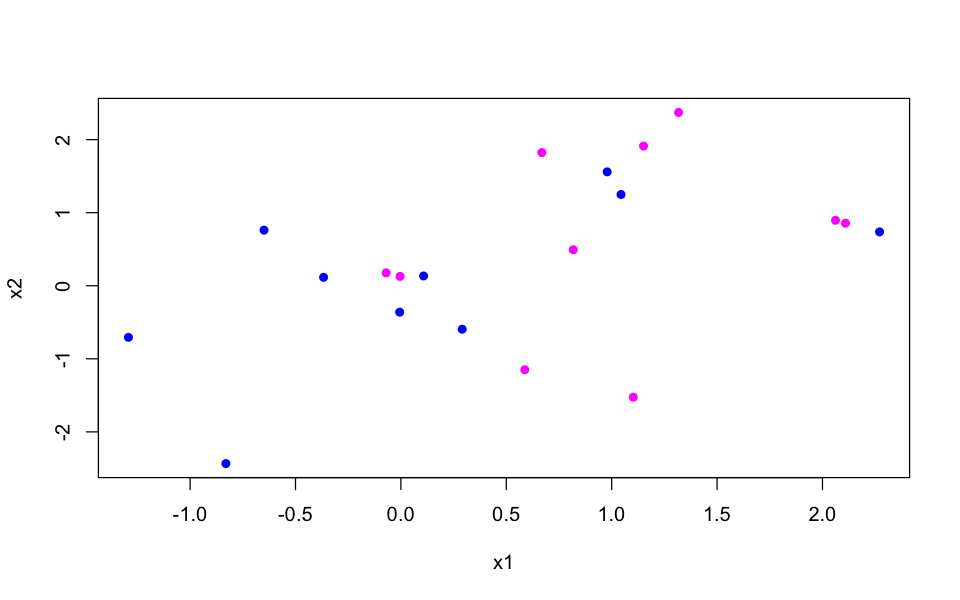

In [7]:
mask = mydata$y==-1

plot(mydata$x1[mask], mydata$x2[mask], col="blue", 
     xlim=c(min(mydata$x1), max(mydata$x1)), ylim = c(min(mydata$x2), max(mydata$x2)),
     xlab='x1', ylab='x2',pch=16)
points(mydata$x1[!mask], mydata$x2[!mask], col="magenta",pch=16)

We can run this and see the points move around, lets try with more data points **go back and set n_neg/n_pos = 100 and 1000 on your own!**

What is x1 and x2?  In this case - we have not specified a physical meaning.  We are just using a gaussian mixture model for practice.  If it helps, you can think of x1 and x2 as amounts of 2 different drugs in a drug combination and the blue as patients that are cured and pink as patients that are still sick.  If we know that certain patients can only tollerate low levels of drug "x1" then we might want to know how high of a dosage to give patients of drug "x2" inorder to cure them - so we might want to find a "cure" boundary in this x1 & x2 space.

Now, we can see that there are 2 distinct populations.  Let's say we want to keep the means of each of the distributions fixed & pull randomly from these fixed-mean distributions.

We can do this by fixing the "seed" of the random means this is the (1) random number.

Let's first practice doing this before going whole hog.  Since we are doing random distributions, we need to set a "seed" for the random number generator

For example:

In [8]:
sample(1:10, 5)

[1]  9  1  7 10  2

If I run this a few times, I get different sets of 5 numbers in the range 1-10:

In [9]:
print(sample(1:10, 5))
print(sample(1:10, 5))
print(sample(1:10, 5))

[1] 4 1 7 3 2
[1] 8 4 1 6 2
[1] 9 5 4 2 8


But let's say I'm testing something and I want to be able to regenerate the same random numbers, we can set the "seed" for our random numbers:

In [10]:
set.seed(554)
print(sample(1:10, 5))
set.seed(554)
print(sample(1:10, 5))
set.seed(554)
print(sample(1:10, 5))

[1] 10  5  9  3  8
[1] 10  5  9  3  8
[1] 10  5  9  3  8


If we run this another few times, we see we get now the same random numbers.

To make sure things are random from now on in RStudio we can reset the seed:

In [11]:
set.seed(NULL)
print(sample(1:10, 5))

[1] 3 1 8 4 5


... and now we get the same random numbers again!

Ok, so let's go back and fix the mean of our distributions:

In [12]:
mean_seed = 238
# and lets do a lot of points
n_neg = 1000
n_pos = 1000

mydata = gmm_distribution2d(n_neg=n_neg, n_pos=n_pos, mean_seed=mean_seed)

... and plot!

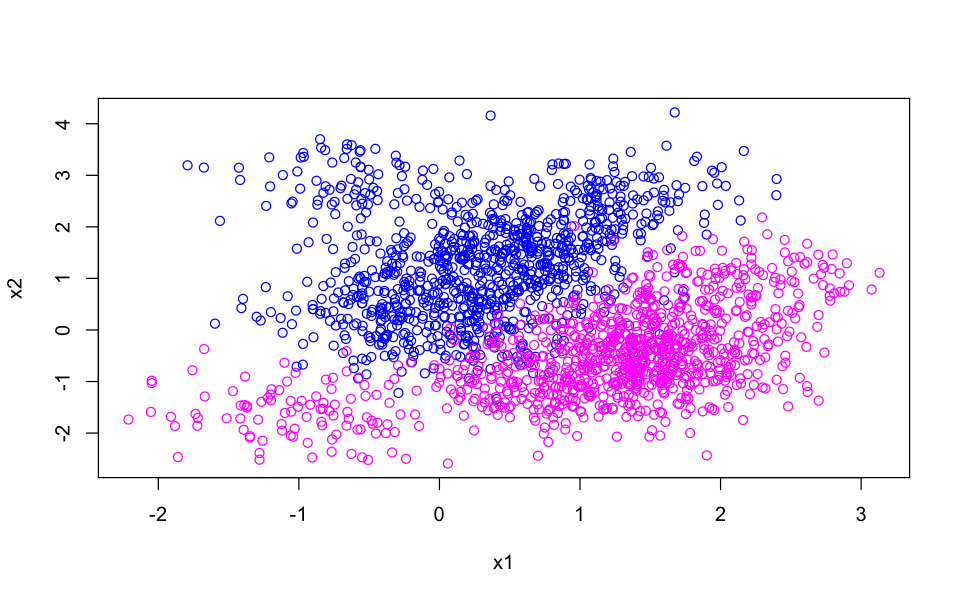

In [13]:
mask = mydata$y == -1

plot(mydata$x1[mask], mydata$x2[mask], col="blue", 
     xlim=c(min(mydata$x1), max(mydata$x1)), ylim = c(min(mydata$x2), max(mydata$x2)),
     xlab='x1', ylab='x2')
points(mydata$x1[!mask], mydata$x2[!mask], col="magenta")

Now you can see that if I run this section a few times, the "middles" of the distributions are fixed, but the drawn points shift around.

We can also fix the actual draws so those are fixed as well and the same data points will be chosen every time this is useful for debugging our code.

In [14]:
data_seed = 52345
mydata = gmm_distribution2d(n_neg=n_neg, n_pos=n_pos, mean_seed=mean_seed, data_seed=data_seed)

Let's plot!

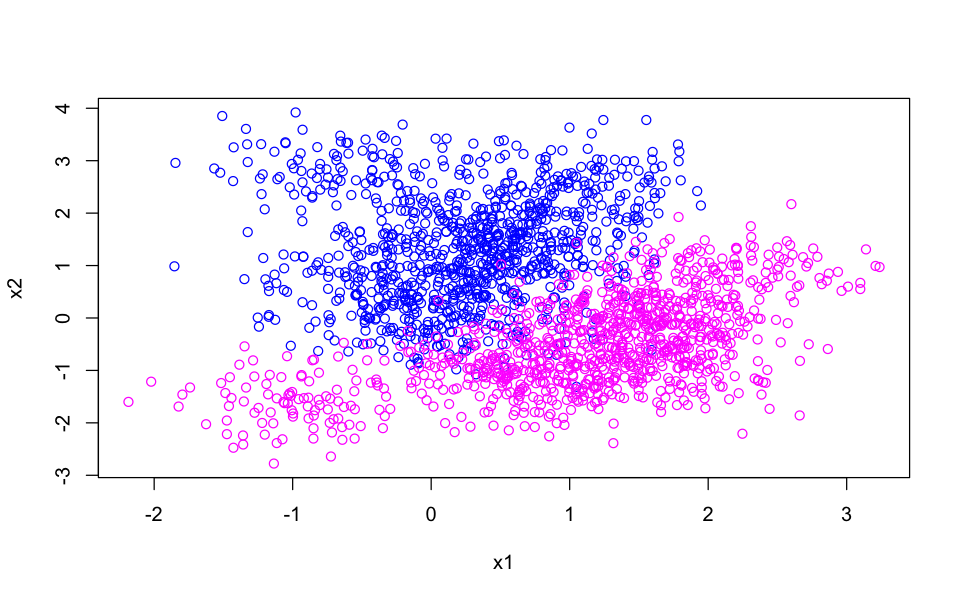

In [15]:
mask = mydata$y == -1

plot(mydata$x1[mask], mydata$x2[mask], col="blue", 
     xlim=c(min(mydata$x1), max(mydata$x1)), ylim = c(min(mydata$x2), max(mydata$x2)),
     xlab='x1', ylab='x2')
points(mydata$x1[!mask], mydata$x2[!mask], col="magenta")

Now we can see that the draws from the underlying distribution are fixed as wellthis was random number (2) in our list above.

Let's try with a smaller simulated dataset for now:

In [16]:
n_neg_sample = 200
n_pos_sample = 200
mean_seed = 238
data_seed = 1232

sample_data = gmm_distribution2d(n_neg=n_neg_sample, n_pos=n_pos_sample, 
                                 mean_seed=mean_seed, data_seed=data_seed)

Note that I'm using a different data seed as we want a different pull.

What are some ways we could think of classifying these?

## 2. Fit Gaussian mixture model with a GLM

What about a GLM model?  Let's try that to see its limitations.

For this, we'd have to map our -1 to zero to keep with our usual nomenclature. This is not totally necessary, but lets be consistent:

In [17]:
levels(sample_data$y) # 1, -1 are our previous levels

[1] "-1" "1"

In [18]:
sample_data_glm = sample_data
levels(sample_data_glm$y) = c("0","1") # relabel
print(sample_data_glm$y)

  [1] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [38] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [75] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[112] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[149] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[186] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[223] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[260] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[297] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[334] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[371] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
Levels: 0 1


GLM it!

In [19]:
glm2 = glm(y~x1+x2,data=sample_data_glm, family=binomial)

In [20]:
summary(glm2)


Call:
glm(formula = y ~ x1 + x2, family = binomial, data = sample_data_glm)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.4166  -0.0935   0.0011   0.1698   2.0029  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -1.1036     0.3016  -3.659 0.000253 ***
x1            3.3728     0.4479   7.531 5.05e-14 ***
x2           -4.0063     0.4825  -8.304  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 554.52  on 399  degrees of freedom
Residual deviance: 127.98  on 397  degrees of freedom
AIC: 133.98

Number of Fisher Scoring iterations: 8


So we see that this is a pretty good fit if we just looked at our p-values.

Let's make a function that returns the probaility we are in 1 or 2 using the methodology for logistic functions as before:

In [21]:
myMultipleProbFunction = function(x1, x2){
  # first, input our cofficients
  ly2 = glm2$coefficients[1] + glm2$coefficients[2]*x1 + glm2$coefficients[3]*x2
  ply2 = exp(ly2)/(1.0 + exp(ly2))
  return(unname(ply2)) # take off label
}

Let's pick a point x1=-1 & x2=4 and see what probability of being in the blue.

Here: "success" is +1, our magenta points "failure" was -1, is now 0, is our blue points so here, our probability is the probabiity of being "magenta", or +1.

For reference, here is our plot of points with the large dataset:

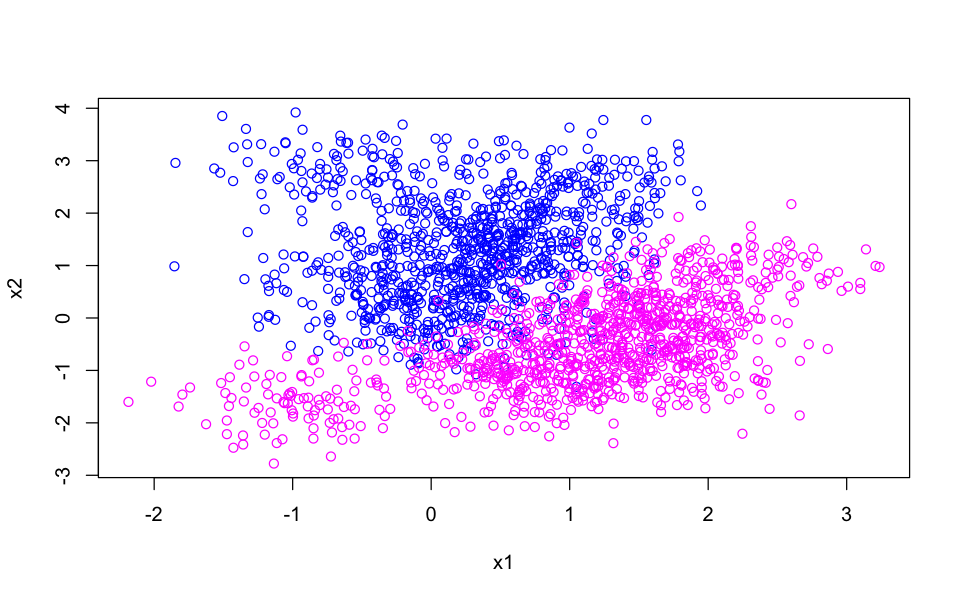

In [22]:
mask = mydata$y == -1

plot(mydata$x1[mask], mydata$x2[mask], col="blue", 
     xlim=c(min(mydata$x1), max(mydata$x1)), ylim = c(min(mydata$x2), max(mydata$x2)),
     xlab='x1', ylab='x2')
points(mydata$x1[!mask], mydata$x2[!mask], col="magenta")

In [23]:
print(myMultipleProbFunction(-1,4)) # small prob, very unlikely magenta
print(myMultipleProbFunction(2,-2)) # large prob, very likely magenta
print(myMultipleProbFunction(0,0)) # 30% chance magenta
print(myMultipleProbFunction(1,-2)) # high probability magenta

[1] 1.247995e-09
[1] 0.9999988
[1] 0.2490679
[1] 0.9999658


How might we plot a "decision" boundary?  Well, we can construct a set of x1 steps, and loop through some x2 steps and record where the probability that we are magenta is higher than some set probability and then mark this value and then plot a line when we are done.  Let's try this!

### 2.A Plot GLM model with `contour`

We can plot this with a contour map, with just some futzing.  We'll do this but plotting *only* the 50% probability contour -- i.e. on the 2D x1-x2 domain where we are equally likely to be classified as magenta or blue.

A few variables we need:

In [24]:
grid_size = 100 # size of our grid (assume equal in x & y)
prob_cut_off = 0.5 # cut at 1/2 - 50% probability of success i.e. equally likely to be blue/pink

How far will our grid span in x1 and x2 - let's cover all space visible:

In [25]:
myx1_seq = seq(-2,4,length=grid_size)
myx2_seq = seq(-2, 4, length=grid_size) # for looping and testing

Let's first make a probability grid - will calculate the probability of success, i.e. probability that a specific grid point should be tagged as being in the "magenta" distribution:

In [26]:
probGrid = matrix(0,grid_size,grid_size) # 100x100 grid
for (i in 1:grid_size){
  for (j in 1:grid_size){
    myProb = myMultipleProbFunction(myx1_seq[i],myx2_seq[j])
    # now, lets save!
    probGrid[i,j] = myProb
  }
}

In [27]:
probGrid # matrix of probabilities

0.5408095,0.4802086,0.4201846,0.3624319,0.3083950,0.2591401,0.2153030,0.1771087,0.1444428,0.1169456,...,3.806282e-10,2.985729e-10,2.342070e-10,1.837170e-10,1.441115e-10,1.130442e-10,8.867426e-11,6.955799e-11,5.456277e-11,4.280021e-11
0.5909783,0.5312597,0.4706322,0.4108590,0.3536063,0.3002656,0.2518364,0.2088864,0.1715815,0.1397619,...,4.669546e-10,3.662892e-10,2.873251e-10,2.253840e-10,1.767960e-10,1.386826e-10,1.087856e-10,8.533374e-11,6.693761e-11,5.250729e-11
0.6393215,0.5816648,0.5216870,0.4610773,0.4015970,0.3448795,0.2922600,0.2446704,0.2026116,0.1661920,...,5.728599e-10,4.493636e-10,3.524904e-10,2.765010e-10,2.168933e-10,1.701358e-10,1.334581e-10,1.046874e-10,8.211906e-11,6.441595e-11
0.6849964,0.6304204,0.5722927,0.5120983,0.4515510,0.3924048,0.3362560,0.2843810,0.2376437,0.1964786,...,7.027846e-10,5.512793e-10,4.324353e-10,3.392115e-10,2.660847e-10,2.087226e-10,1.637265e-10,1.284305e-10,1.007437e-10,7.902548e-11
0.7273539,0.6766524,0.6214297,0.5628685,0.5025007,0.4420600,0.3832882,0.3277402,0.2766315,0.2307570,...,8.621761e-10,6.763094e-10,5.305116e-10,4.161446e-10,3.264328e-10,2.560608e-10,2.008596e-10,1.575586e-10,1.235923e-10,9.694846e-11
0.7659618,0.7196727,0.6681944,0.6123547,0.5533986,0.4929013,0.4326111,0.3742529,0.3193363,0.2690137,...,1.057718e-09,8.296964e-10,6.508316e-10,5.105262e-10,4.004677e-10,3.141354e-10,2.464146e-10,1.932929e-10,1.516231e-10,1.189364e-10
0.8006013,0.7590079,0.7118609,0.6596265,0.6032012,0.5438899,0.4833071,0.4232111,0.3653045,0.3110483,...,1.297608e-09,1.017872e-09,7.984402e-10,6.263136e-10,4.912938e-10,3.853814e-10,3.023014e-10,2.371317e-10,1.860112e-10,1.459111e-10
0.8312435,0.7944004,0.7519143,0.7039209,0.6509529,0.5939748,0.5343490,0.4737252,0.4138663,0.3564481,...,1.591906e-09,1.248725e-09,9.795264e-10,7.683615e-10,6.027192e-10,4.727859e-10,3.708633e-10,2.909132e-10,2.281985e-10,1.790038e-10
0.8580120,0.8257882,0.7880577,0.7446822,0.6958556,0.6421782,0.5846816,0.5247829,0.4641626,0.4045831,...,1.952950e-09,1.531936e-09,1.201683e-09,9.426259e-10,7.394159e-10,5.800137e-10,4.549752e-10,3.568923e-10,2.799539e-10,2.196019e-10
0.8811415,0.8532692,0.8201946,0.7815732,0.7373129,0.6876681,0.6333072,0.5753277,0.5151986,0.4546263,...,2.395879e-09,1.879379e-09,1.474225e-09,1.156413e-09,9.071155e-10,7.115608e-10,5.581635e-10,4.378354e-10,3.434475e-10,2.694076e-10
0.9009383,0.8770606,0.8483960,0.8144618,0.7749469,0.7298081,0.6793617,0.6243448,0.5659196,0.5056031,...,2.939264e-09,2.305622e-09,1.808579e-09,1.418688e-09,1.112849e-09,8.729428e-10,6.847550e-10,5.371365e-10,4.213414e-10,3.305092e-10


Now we'll "hack" the `contour` function to plot the line of where `probGrid` = 0.5 (50%):

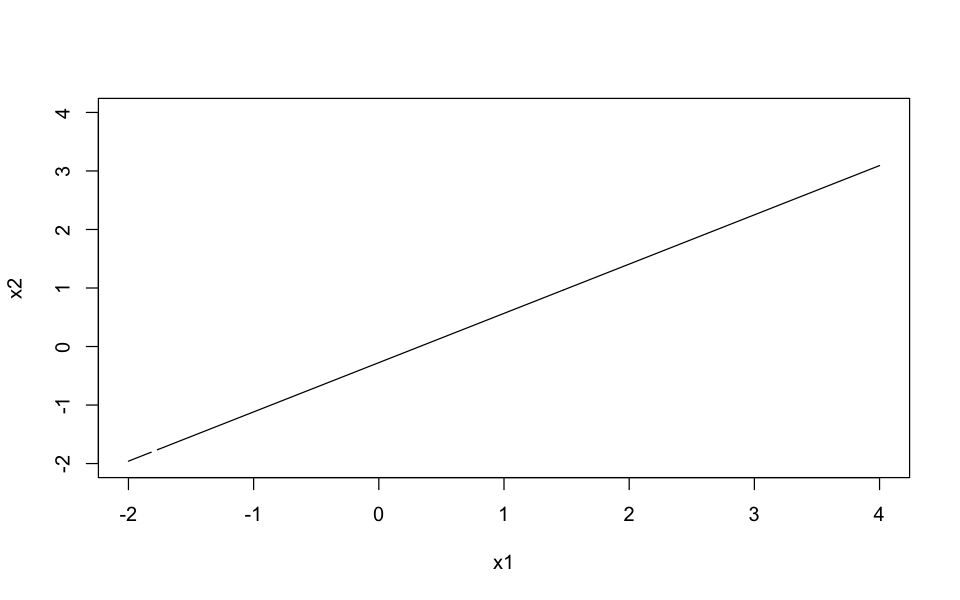

In [28]:
contour(myx1_seq,myx2_seq, probGrid, levels=0.5, labels="", # setting labels to empty means no contour line labels
        xlab='x1', ylab='x2')

So, the line is nice, but let's overplot our points:

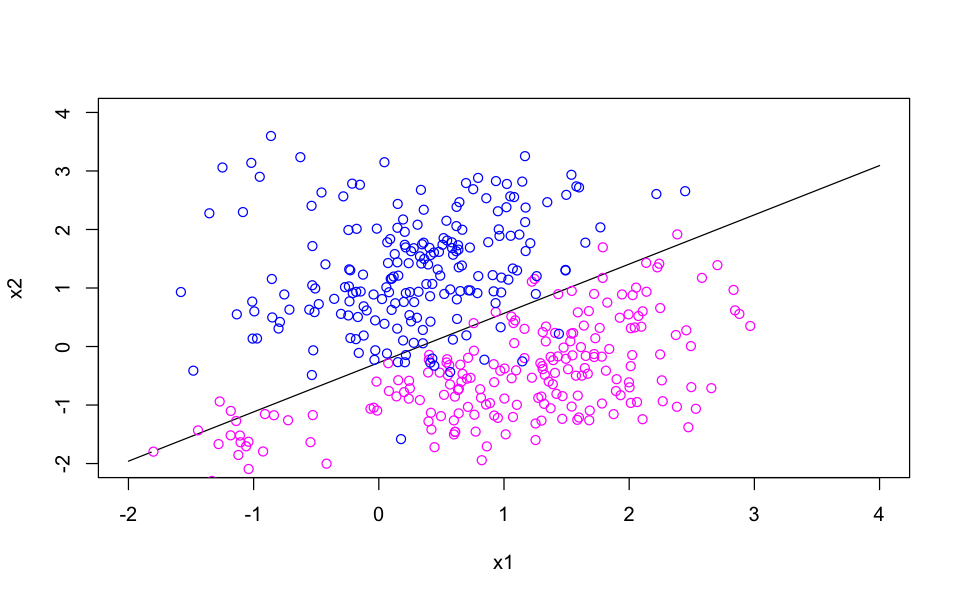

In [29]:
contour(myx1_seq,myx2_seq, probGrid, levels=0.5, labels="", # setting labels to empty means no contour line labels
        xlab='x1', ylab='x2')

mask = sample_data$y == 1
points(sample_data$x1[mask], sample_data$x2[mask], col="magenta")
points(sample_data$x1[!mask], sample_data$x2[!mask], col="blue")

## 3. IN GROUPS (Skip for online): try with different seeds

1. redo this with different random seeds and see what changes, use "contour" or construct lines to show the cut-off
  * Do you think our GLM model classifies the boundaries well?  Why or why not?

You might have to use: set.seed(NULL) to get random seeds if that is what you want.

**BONUS:** check out some of the other distributions in synthetic_distributions.R
  * How does classifying for boston_cream_doughnut distribtuion look?  Why do you expect this to work/better or worse?



**ANS 1.** With different seeds

In [30]:
set.seed(NULL)

n_neg_sample = 1000
n_pos_sample = 1000
sample_data = gmm_distribution2d(n_neg=n_neg_sample, n_pos=n_pos_sample)

Let's plot!

Can even make a plotting function if we are feeling fancy:

In [31]:
plotMyData = function(the_data){
  plot(the_data$x1[the_data$y==-1], the_data$x2[the_data$y==-1], col="blue", 
       xlim=c(min(the_data$x1), max(the_data$x1)), ylim = c(min(the_data$x2), max(the_data$x2)),
       xlab='x1', ylab='x2')
  points(the_data$x1[the_data$y==1], the_data$x2[the_data$y == 1], col="magenta")
}

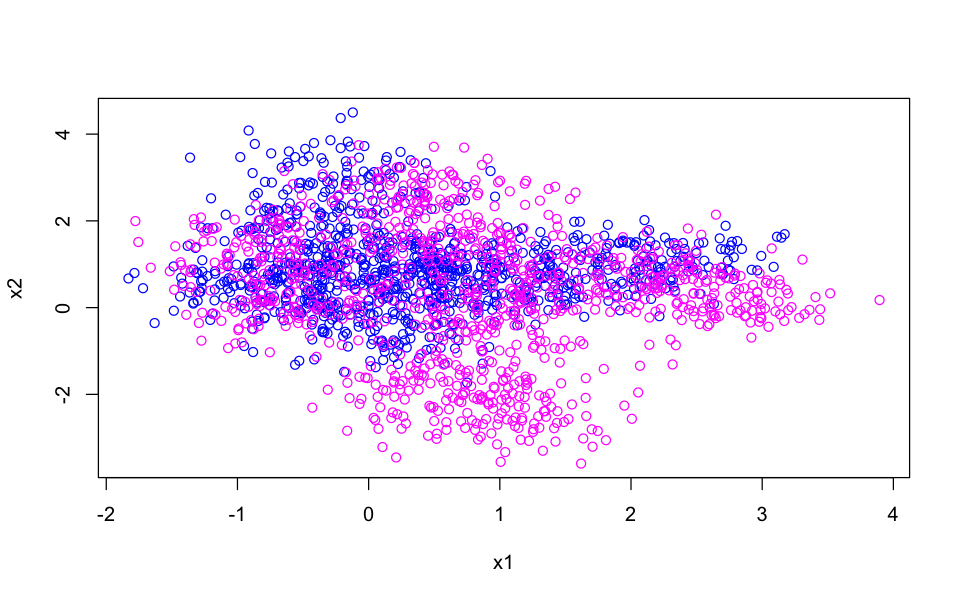

In [32]:
plotMyData(sample_data)

What about a GLM model?  For this, we'd have to map our -1 to zero to keep with our usual nomenclature:

In [33]:
sample_data_glm = sample_data
levels(sample_data_glm$y) = c("0","1")
head(sample_data_glm$y)

[1] 1 1 1 1 1 1
Levels: 0 1

In [34]:
glm2 = glm(y~x1+x2,data=sample_data_glm, family=binomial)

In [35]:
summary(glm2)


Call:
glm(formula = y ~ x1 + x2, family = binomial, data = sample_data_glm)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-1.58617  -1.12041  -0.01789   1.08225   1.78078  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.04870    0.05917   0.823    0.411    
x1           0.31658    0.04387   7.216 5.35e-13 ***
x2          -0.36873    0.03831  -9.626  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 2772.6  on 1999  degrees of freedom
Residual deviance: 2590.7  on 1997  degrees of freedom
AIC: 2596.7

Number of Fisher Scoring iterations: 4


Using what we did before let's make a function that returns the probaility we are in 1 or 2:

In [36]:
myMultipleProbFunction = function(x1, x2){
  # first, input our cofficients
  ly2 = glm2$coefficients[1] + glm2$coefficients[2]*x1 + glm2$coefficients[3]*x2
  ply2 = exp(ly2)/(1.0 + exp(ly2))
  return(ply2)
}

Fill a probability grid again:

In [37]:
grid_size = 100 # size of our grid (assume equal in x & y)
prob_cut_off = 0.5 # cut at 1/2
myx1_seq = seq(-4,4,length=grid_size)
myx2_seq = seq(-4, 4, length=grid_size) # for looping and testing

probGrid = matrix(0,grid_size,grid_size) # 100x100 grid
for (i in 1:grid_size){
  for (j in 1:grid_size){
    myProb = myMultipleProbFunction(myx1_seq[i],myx2_seq[j])
    # now, lets save!
    probGrid[i,j] = myProb
  }
}

Plot with our hacked contour!

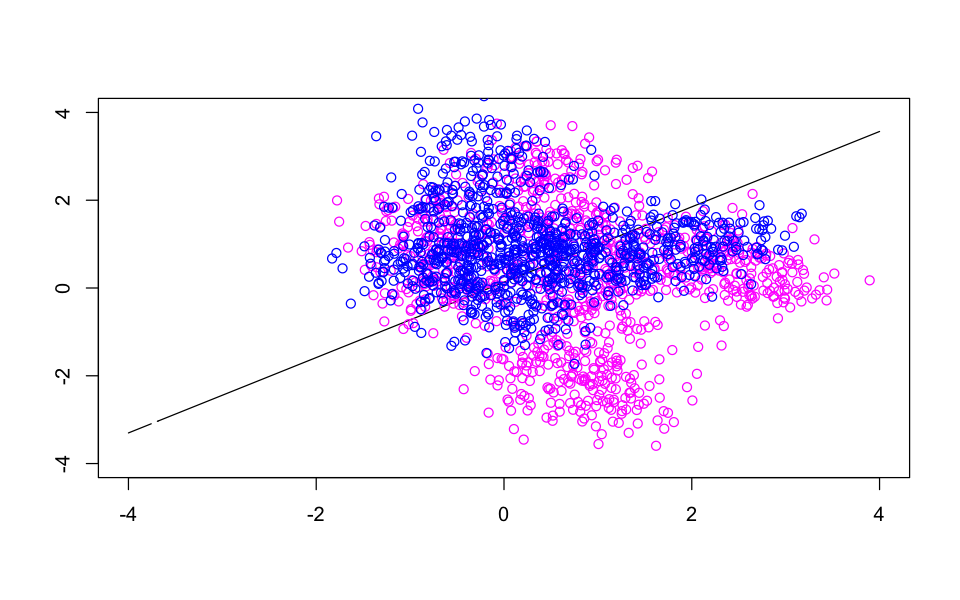

In [38]:
contour(myx1_seq,myx2_seq, probGrid, levels=0.5, labels="")
points(sample_data$x1[sample_data$y==1], sample_data$x2[sample_data$y == 1], col="magenta")
points(sample_data$x1[sample_data$y==-1], sample_data$x2[sample_data$y == -1], col="blue")

**THE BONUS**

In [39]:
n_neg_sample = 1000
n_pos_sample = 1000
sample_data = boston_cream_doughnut(n_neg=n_neg_sample, n_pos=n_pos_sample)

In [40]:
sample_data_glm = sample_data
levels(sample_data_glm$y) = c("0","1")
head(sample_data_glm$y)

[1] 0 0 0 0 0 0
Levels: 0 1

In [41]:
glm2 = glm(y~x1+x2,data=sample_data_glm, family=binomial)

In [42]:
summary(glm2)


Call:
glm(formula = y ~ x1 + x2, family = binomial, data = sample_data_glm)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-1.21038  -1.17642  -0.01513   1.17402   1.24667  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)
(Intercept) -0.002579   0.044781  -0.058    0.954
x1           0.033603   0.054483   0.617    0.537
x2           0.072789   0.054669   1.331    0.183

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 2772.6  on 1999  degrees of freedom
Residual deviance: 2770.4  on 1997  degrees of freedom
AIC: 2776.4

Number of Fisher Scoring iterations: 3


In [43]:
# lets make a function that returns the probaility we are in 1 or 2
myMultipleProbFunction = function(x1, x2){
  # first, input our cofficients
  ly2 = glm2$coefficients[1] + glm2$coefficients[2]*x1 + glm2$coefficients[3]*x2
  ply2 = exp(ly2)/(1.0 + exp(ly2))
  return(ply2)
}

In [44]:
grid_size = 100 # size of our grid (assume equal in x & y)
prob_cut_off = 0.5 # cut at 1/2
myx1_seq = seq(-4,4,length=grid_size)
myx2_seq = seq(-4, 4, length=grid_size) # for looping and testing

probGrid = matrix(0,grid_size,grid_size) # 100x100 grid
for (i in 1:grid_size){
  for (j in 1:grid_size){
    myProb = myMultipleProbFunction(myx1_seq[i],myx2_seq[j])
    # now, lets save!
    probGrid[i,j] = myProb
  }
}

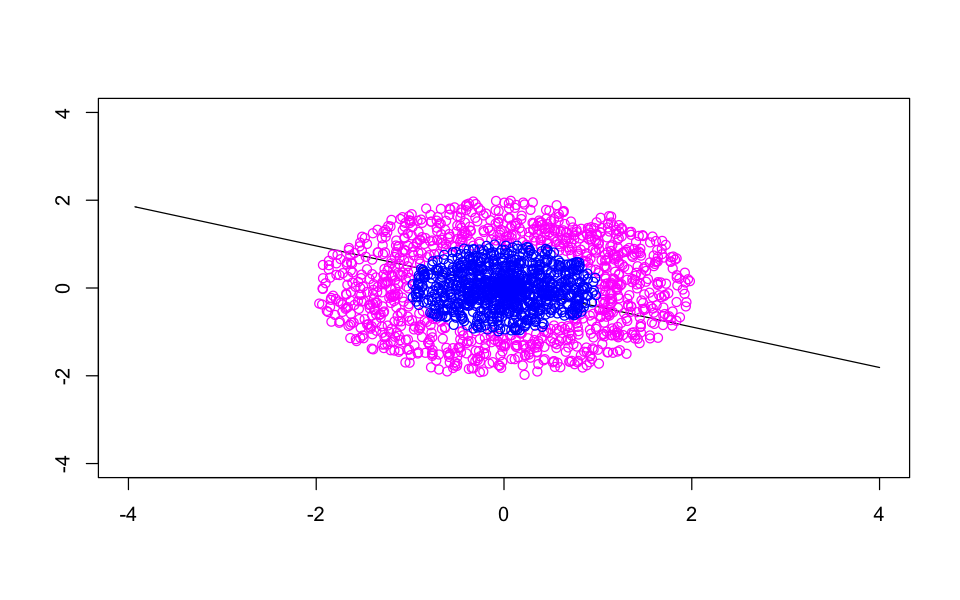

In [45]:
contour(myx1_seq,myx2_seq, probGrid, levels=0.5, labels="")
points(sample_data$x1[sample_data$y==1], sample_data$x2[sample_data$y == 1], col="magenta")
points(sample_data$x1[sample_data$y==-1], sample_data$x2[sample_data$y == -1], col="blue")

**------- END SKIPPED IF ONLINE PART --------**

## 4. BACK TO SLIDES TO TALK ABOUT ISSUES WITH LOGISTIC REGRESSION

## 5. Redo decision boundary with KNN

So, we've seen a lot of problems with logistic regression!  Let's try re-doing this but using KNN!

To help us with future things, we're going to rename and reformat the dataset we've been using.

We'll label our dataset as our "training" sample. Then we'll "test" how well we do with a set of grid points.

Technically, the "train" and "test" datasets usually are splits of our collected dataset, but we'll get more into that when we are talking about Cross Validation.

Make sure we are using our original dataset (if we've gone through the boston cream donut):

In [59]:
n_neg_sample = 200
n_pos_sample = 200
mean_seed = 238
data_seed = 1232

sample_data = gmm_distribution2d(n_neg=n_neg_sample, n_pos=n_pos_sample, 
                                 mean_seed=mean_seed, data_seed=data_seed)

For formatting, make columns:

In [60]:
train.X = cbind(sample_data$x1, sample_data$x2)

In [61]:
head(train.X) # makes lists of the x1/x2 combinations

1.320868,-0.9800956
1.719651,-0.1285048
2.106908,-1.2425100
2.003051,-0.6972715
-1.109312,-1.5213823
1.637903,0.3575095


Grid of new x1 & x2 values we'd like to have a boundary for:

In [62]:
grid_size = 10 # new grid size
x1_new = seq(-2,4,length=grid_size)
x2_new = seq(-2,4,length=grid_size)

In [63]:
head(x1_new)

[1] -2.0000000 -1.3333333 -0.6666667  0.0000000  0.6666667  1.3333333

In [64]:
head(x2_new)

[1] -2.0000000 -1.3333333 -0.6666667  0.0000000  0.6666667  1.3333333

To format things for KNN we'll take these two arrays and make a grid by generating all the possible combinations of `x1_new` and `x2_new`.  We can do this by using `expand.grid`:

In [65]:
test.X = expand.grid(x1_new,x2_new)

In [66]:
head(test.X)

Var1,Var2
-2.0000000,-2
-1.3333333,-2
-0.6666667,-2
0.0000000,-2
0.6666667,-2
1.3333333,-2


Now we have all the combinations of `x1_new` and `x2_new`:

In [67]:
nrow(test.X) # 10 x 10 = 100

[1] 100

Now, lets pick the "k" of our fit - how many neighbors do we want to average over?

In [68]:
k = 5 # just a random choice for now

Ok, let's make a prediction!

Here train.X and test.X are our matrix formatting from above sample_data$y is a -1 or a +1 and setting `prob=T` just means we want to output our probability too.  We'll use this for our `contour` hack.

In [69]:
knn_train_prediction = knn(train.X, test.X, sample_data$y, k=k, prob=T) # set k

Let's take a look!

In [70]:
knn_train_prediction

[1] 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 
 [26] 1  1  1  1  1  -1 -1 -1 -1 1  1  1  1  1  1  -1 -1 -1 -1 -1 1  1  1  1  1 
 [51] -1 -1 -1 -1 -1 -1 1  1  1  1  -1 -1 -1 -1 -1 -1 1  1  1  1  -1 -1 -1 -1 -1
 [76] -1 -1 -1 1  1  -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
attr(,"prob")
  [1] 1.0 1.0 1.0 0.8 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 0.8 1.0 1.0 1.0 1.0
 [19] 1.0 1.0 0.8 0.8 0.8 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 0.6 1.0
 [37] 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 0.8 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
 [55] 1.0 0.8 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 0.6 0.6 0.8 0.8 1.0 1.0
 [73] 1.0 1.0 1.0 1.0 1.0 0.8 0.6 0.6 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 0.8 0.6
 [91] 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 0.8
Levels: -1 1

This is how our KNN has classified points on our `test.X` grid as either thing "-1" or thing "1".

Let's plot this using our "contour" function again.

We need to grab the probability of belonging to a group 0.5 as the boundary - prob=1 means positive group, prob=0 means negative group:

In [71]:
prob = attr(knn_train_prediction, "prob")

In [72]:
prob

[1] 1.0 1.0 1.0 0.8 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 0.8 1.0 1.0 1.0 1.0
 [19] 1.0 1.0 0.8 0.8 0.8 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 0.6 1.0
 [37] 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 0.8 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
 [55] 1.0 0.8 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 0.6 0.6 0.8 0.8 1.0 1.0
 [73] 1.0 1.0 1.0 1.0 1.0 0.8 0.6 0.6 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 0.8 0.6
 [91] 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 0.8

Now we'll do a bit of a hack - it just flips the probability so that we pick out *only* the 0.5 line for prob = -1.

This is just fancy stuff for plotting:

In [73]:
prob2 = ifelse(knn_train_prediction=="1", prob, 1-prob)
prob2

[1] 1.0 1.0 1.0 0.8 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 0.8 1.0 1.0 1.0 1.0
 [19] 1.0 1.0 0.8 0.8 0.8 1.0 1.0 1.0 1.0 1.0 1.0 1.0 0.0 0.0 0.0 0.0 0.6 1.0
 [37] 1.0 1.0 1.0 1.0 0.0 0.0 0.0 0.0 0.0 0.8 1.0 1.0 1.0 1.0 0.0 0.0 0.0 0.0
 [55] 0.0 0.2 1.0 1.0 1.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.6 0.6 0.8 0.8 0.0 0.0
 [73] 0.0 0.0 0.0 0.0 0.0 0.2 0.6 0.6 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.2 0.4
 [91] 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.2

Basically, we are now calculating the probability of "success" instead of probability of belonging in a specific group.

Formatting for contour plots (like before):

In [74]:
prob2 = matrix(prob2, grid_size, grid_size)
prob2

1.0,1.0,0.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.0,1.0,0.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.0,1.0,0.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.8,0.8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.0,1.0,1.0,0.6,0.0,0.0,0.0,0.0,0.0,0.0
1.0,1.0,1.0,1.0,0.8,0.2,0.0,0.0,0.0,0.0
1.0,1.0,1.0,1.0,1.0,1.0,0.6,0.0,0.0,0.0
1.0,1.0,1.0,1.0,1.0,1.0,0.6,0.2,0.0,0.0
1.0,1.0,1.0,1.0,1.0,1.0,0.8,0.6,0.2,0.0
1.0,1.0,1.0,1.0,1.0,1.0,0.8,0.6,0.4,0.2


Finally we are in position to do the contour plotting again!

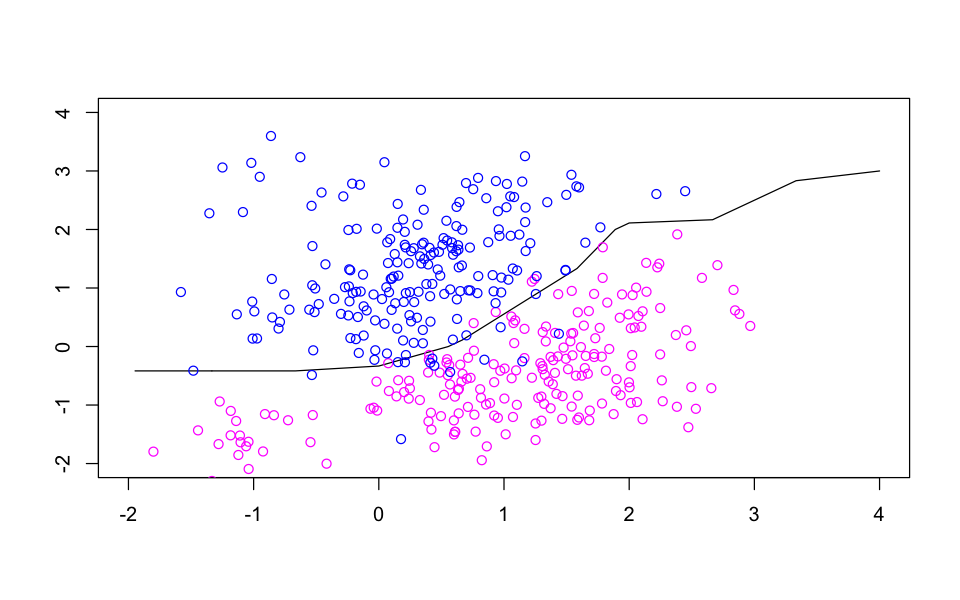

In [75]:
contour(x1_new,x2_new, prob2, levels=0.5, labels="")

mask = sample_data$y == 1
points(sample_data$x1[mask], sample_data$x2[mask], col="magenta")
points(sample_data$x1[!mask], sample_data$x2[!mask], col="blue")

Now we have something that looks like a boundary!  Neato!!

Now we can go back and play around with our model **ON YOUR OWN**
  1. make a finer grid with changing grid_size
  2. changing the # of neearest neighbors with k

Let's look at a few different k's all at once by doing a 3x3 plot with different k-values:

In [76]:
k_values = c(1, 3, 5, 9, 15, 20, 50, 100, 300)

Doing plots over the same `test.X` grid:

In [77]:
grid_size = 10
x1_new = seq(-2,4, length=grid_size) # same as myx1_seq
x2_new = seq(-2,4, length=grid_size) # same as myx2_seq
test.X = expand.grid(x1_new, x2_new)

Loop and plot!

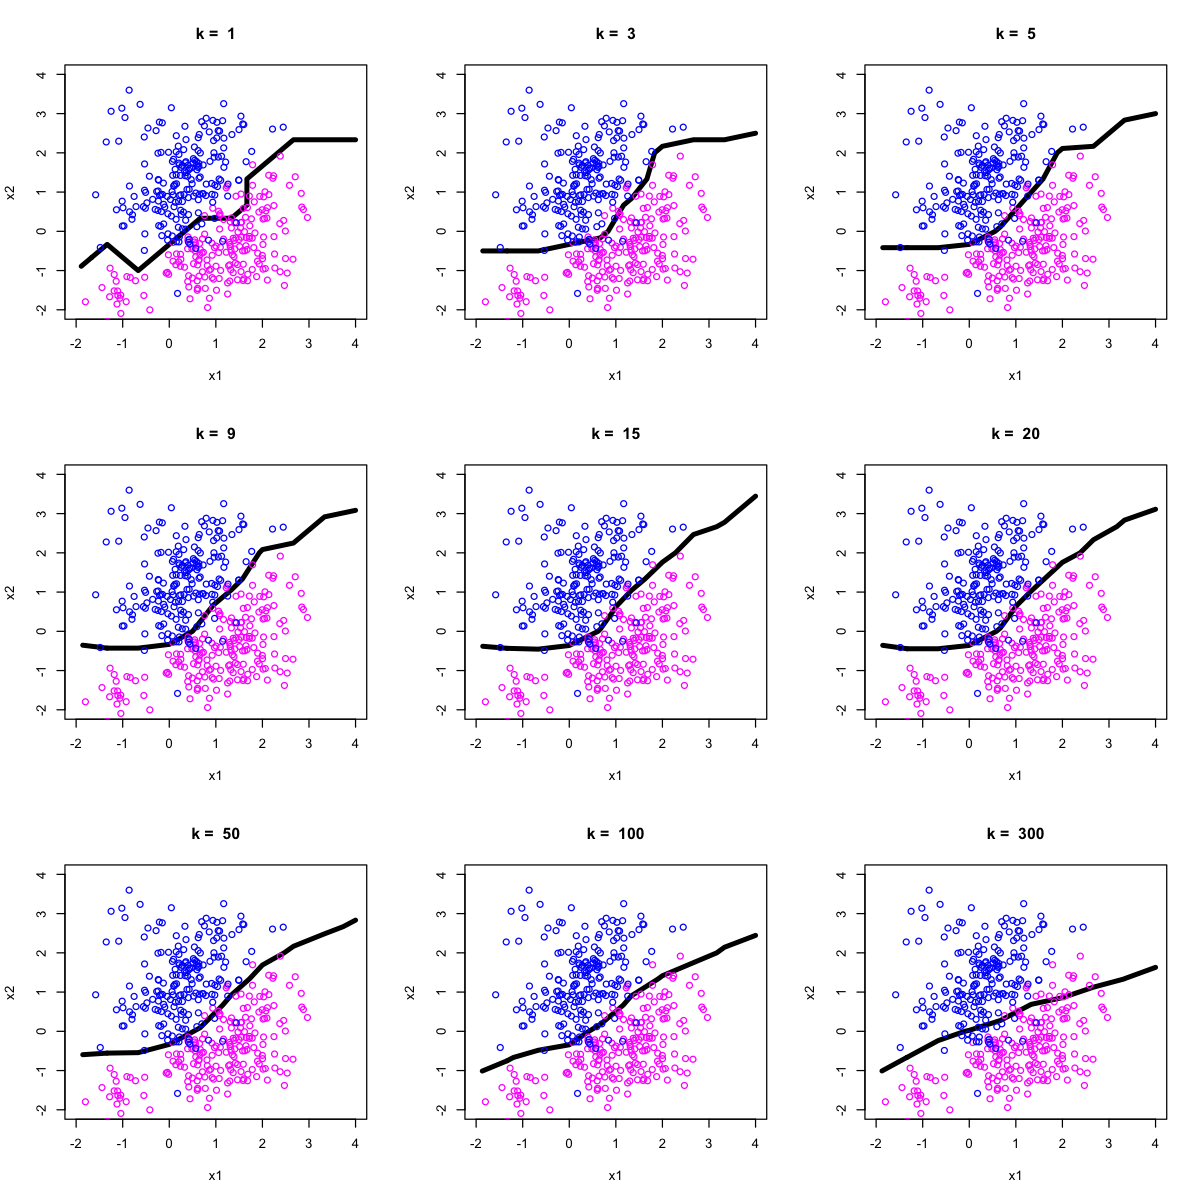

In [78]:
options(repr.plot.width=10, repr.plot.height=10)

par(mfrow=c(3,3))

for (i in 1:length(k_values)){
  # let's make prediction!
  knn_train_prediction = knn(train.X, test.X, 
                             sample_data$y, 
                             k=k_values[i], prob=TRUE)
  # grab classification prob and transform it for
  #  plotting with contour plot
  prob = attr(knn_train_prediction,"prob")
  # some fancy stuff for formatting
  prob2 = ifelse(knn_train_prediction=="1", prob, 1-prob)
  prob2 = matrix(prob2, grid_size, grid_size)
  # make title labels
  titleLab = paste("k = ", toString(k_values[i]))
  
  # redo the decision boundary plot with our KNN model
  contour(x1_new, x2_new, prob2, levels=0.5, labels="", 
          xlab='x1', ylab='x2', main=titleLab, lwd=4)
  points(sample_data$x1[sample_data$y==1], 
         sample_data$x2[sample_data$y==1], col="magenta")
  points(sample_data$x1[sample_data$y==-1], 
         sample_data$x2[sample_data$y==-1], col="blue")  
}

Things to note: if we use a very small # of neightbors we get a very squiggly line, but the more neighbors we include the more linear the line looks.

But what is the best k here?  Will it be the same k for all distributions? Keep this question in mind!!

## 6. Example: KNN with the boston cream donut distribution

1. Redo the analysis with the `boston_cream_doughnut` distribution, which is called like so:

In [89]:
n_neg_sample = 200
n_pos_sample = 200
sample_data = boston_cream_doughnut(n_neg=n_neg_sample, n_pos=n_pos_sample)

**BONUS:** what if you change k? What happens if it is smaller?  Or larger?  What looks like the k for a "best" fit?
  * Plot a matrix of classifications for different k and see what the differences are.
  * You can use either distribution (2 gaussians or boston cream)
  * How does this change with different random seeds?  (note: for boston cream, there is no random seed input)
  * How do things change with more or less sample points?  Or grid points?


**ANS 1**

  [1] 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
 [19] 1.0 1.0 1.0 1.0 1.0 0.8 0.8 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 0.6 1.0 1.0
 [37] 0.6 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 0.6 1.0
 [55] 1.0 1.0 1.0 0.6 1.0 1.0 1.0 1.0 1.0 0.6 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
 [73] 1.0 1.0 1.0 0.6 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
 [91] 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0


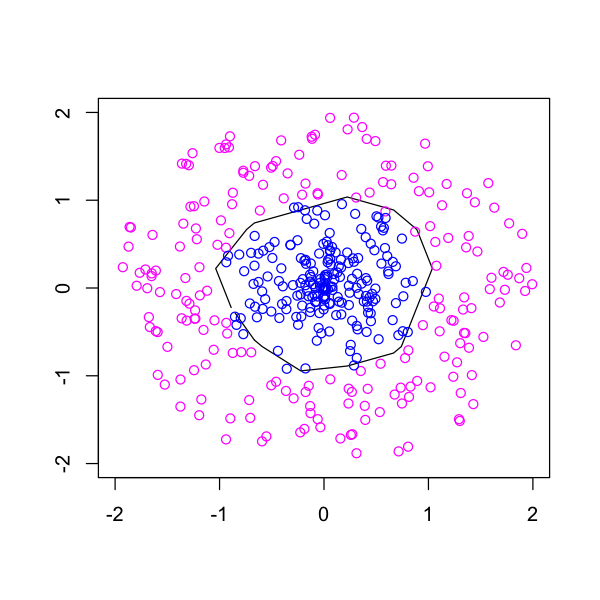

In [101]:
n_neg_sample = 200
n_pos_sample = 200
sample_data = boston_cream_doughnut(n_neg=n_neg_sample, n_pos=n_pos_sample)

# For formatting, make columns:
train.X = cbind(sample_data$x1, sample_data$x2)

# Grid of new x1 & x2 values we'd like to have a boundary for:
grid_size = 10 # new grid size
x1_new = seq(-2,2,length=grid_size)
x2_new = seq(-2,2,length=grid_size)
# new x1 and x2 grid => like collapsing a matrix
test.X = expand.grid(x1_new,x2_new)

# now, lets pick the "k" of our fit
k = 5

# ok, lets make a prediction!
knn_train_prediction = knn(train.X, test.X, sample_data$y, k=k, prob=T) # set k

options(repr.plot.width=5, repr.plot.height=5)

# lets plot this using our "contour" function again

# now, we are grabbing the probability of belonging to a group
# 0.5 is the boundary
# 1 means positive group, 0 means negative group
prob = attr(knn_train_prediction, "prob")
print(prob)

# this just flips the probability so that we
#  pick out *only* the 0.5 line for prob = -1
# this is just some fancy stuff for plotting
prob2 = ifelse(knn_train_prediction=="1", prob, 1-prob)

prob2 = matrix(prob2, grid_size, grid_size)

par(mfrow=c(1,1))
contour(x1_new,x2_new, prob2, levels=0.5, labels="")
points(sample_data$x1[sample_data$y==1], sample_data$x2[sample_data$y == 1], col="magenta")
points(sample_data$x1[sample_data$y==-1], sample_data$x2[sample_data$y == -1], col="blue")

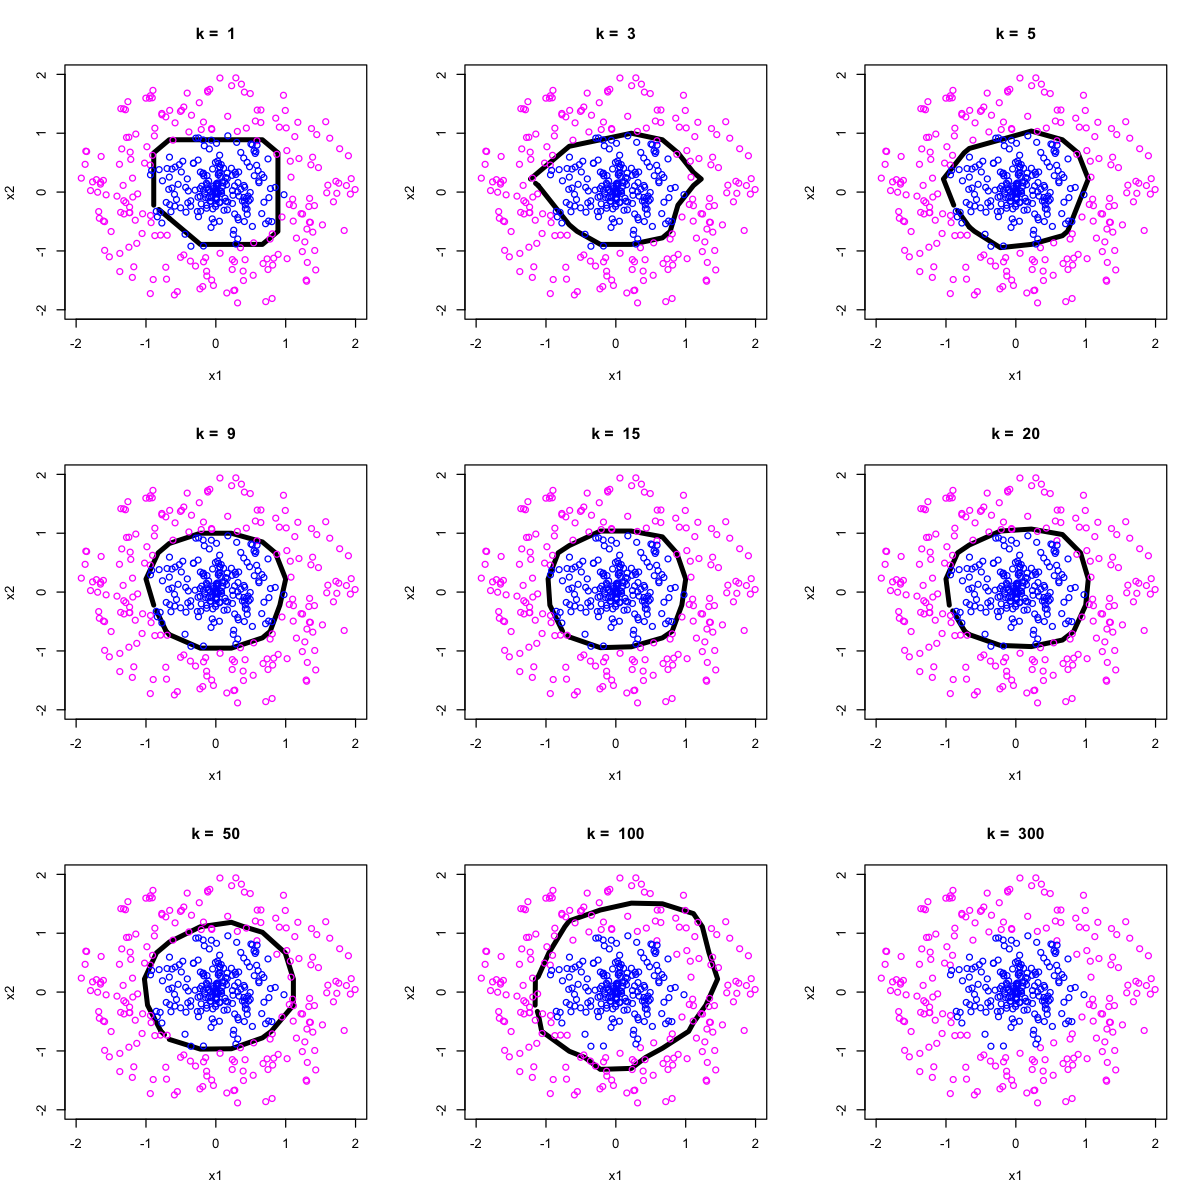

In [102]:
# BONUS:

# ok, lets look at a few different k's all at once
k_values = c(1, 3, 5, 9, 15, 20, 50, 100, 300)

options(repr.plot.width=10, repr.plot.height=10)

train_data = sample_data

par(mfrow = c(3,3))
for( i in 1:length(k_values)){
  knn_train_prediction = knn(train.X, test.X, train_data$y, k=k_values[i], prob=T)
  # grab stuff for plotting boundary
  prob = attr(knn_train_prediction, "prob")
  prob2 = ifelse(knn_train_prediction=="1", prob, 1-prob)
  prob2 = matrix(prob2, grid_size, grid_size)
  # make title labels
  titleLab = paste("k = ", toString(k_values[i]))
  # now plot
  contour(x1_new, x2_new, prob2, levels=0.5, labels="", lwd=4, xlab="x1", ylab="x2", main=titleLab)
  points(train_data$x1[train_data$y==1], train_data$x2[train_data$y==1], col="magenta")
  points(train_data$x1[train_data$y==-1], train_data$x2[train_data$y==-1], col="blue")
}
